In [19]:
import numpy as np
from qiskit.circuit.library                   import RYGate,RZGate,RXGate,UGate,NLocal,TwoLocal,RealAmplitudes,XGate,HGate, RXXGate, RYYGate, RZZGate
from qiskit.circuit                           import Parameter
from qiskit.aqua.components.optimizers        import L_BFGS_B,COBYLA,CG,ADAM,SPSA,AQGD
from qiskit.aqua.components.initial_states    import *
from qiskit.aqua.algorithms                   import VQE
from qiskit.aqua                              import QuantumInstance,aqua_globals

from qiskit                                   import IBMQ
from qiskit.providers.aer.backends.aerbackend import AerBackend
from qiskit.providers.ibmq.ibmqbackend        import IBMQBackend
from qiskit.providers.aer                     import noise
from qiskit.providers.aer.noise               import NoiseModel
from qiskit.ignis.mitigation.measurement      import (complete_meas_cal,CompleteMeasFitter)
import logging
from qiskit.aqua                              import set_qiskit_aqua_logging
#set_qiskit_aqua_logging(logging.DEBUG) 

from   qiskit                                 import *
from   qiskit.quantum_info                    import Pauli,Operator
from   qiskit.aqua.operators                  import SummedOp,PauliOp,CircuitStateFn,WeightedPauliOperator, StateFn, PauliExpectation, CircuitSampler,AerPauliExpectation
from   qiskit.aqua.operators.primitive_ops    import MatrixOp
from   qiskit.aqua.operators.legacy           import MatrixOperator,op_converter
from   qiskit.aqua.algorithms                 import NumPyEigensolver,NumPyMinimumEigensolver
from   qiskit.compiler                        import transpile
from qiskit.aqua.operators                    import X, Y, Z, I
from qiskit.aqua.operators.gradients          import Gradient
from qiskit.converters                        import circuit_to_gate
from qiskit.compiler                          import transpile

import math
from math                                     import isclose
import matplotlib 
import matplotlib.pyplot as plt
from IPython.display                          import display, Markdown
import itertools

from scipy import linalg as LA
from scipy.optimize                           import curve_fit
import functools
import time

# Tomography functions
from qiskit.ignis.verification.tomography     import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography     import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography     import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement    as mc
import qiskit.ignis.mitigation                as mit

#### Functions to define spin operators and Hamiltonian

In [2]:
def generate_pauli(idx_x,idx_z,n):
    '''
    Args:
       n   (integer)
       idx (List)
    Returns:
       tensor product of Pauli operators acting on qubits in idx
       Y = iZX
       P0 P1 P2 P3 P4
       Pi = (X)^a (Z)^b
    '''
    xmask = [0]*n
    zmask = [0]*n
    for i in idx_x: xmask[i] = 1
    for i in idx_z: zmask[i] = 1
    a_x = np.asarray(xmask,dtype=np.bool)
    a_z = np.asarray(zmask,dtype=np.bool)
    return Pauli(a_z,a_x)

#The following function is used to define the operators that appear in the Heisenberg hamiltonian above
#In PauliOp the default coefficient is 1.0
def generate_Heisenberg(nqubit,nn_list):
    pauli_list = []
    for (i,j) in nn_list:
        xixj = PauliOp(generate_pauli([i,j],[],nqubit));    pauli_list.append(xixj)
        yiyj = PauliOp(generate_pauli([i,j],[i,j],nqubit)); pauli_list.append(yiyj)
        zizj = PauliOp(generate_pauli([],[i,j],nqubit));    pauli_list.append(zizj)
    H = SummedOp(pauli_list)
    return H

#Here we define the spin operators acting on site i
#We note that this function returns the name of the operator (site+component) and its value
def generate_spin_operators(nqubit):
    spins = []
    for i in range(nqubit):
        xi = generate_pauli([i],[],nqubit);  spins.append( (str(i)+'x',PauliOp(xi,1.0)) )
        yi = generate_pauli([i],[i],nqubit); spins.append( (str(i)+'y',PauliOp(yi,1.0)) )
        zi = generate_pauli([],[i],nqubit);  spins.append( (str(i)+'z',PauliOp(zi,1.0)) )
    return spins

#We note that the argument aux_operators will be the output of function generate_spin_operators
def diagonalize_H(H,aux_operators):
    '''
    k = number of eigenvalues/eigenvectors to find
    H |ci) = Ei |ci)
    Ai = (ci|A|ci)
    aux_ops: list of length k; each element is an array of shape (nprops,2) for real and imaginary part
    '''
    ee = NumPyEigensolver(operator=H,k=2**H.num_qubits,aux_operators=[s for name_s,s in aux_operators])
    ee = ee.run()
    energies = np.real(ee['eigenvalues'])
    psi = ee['eigenstates']
    aux_ops = ee['aux_operator_eigenvalues']
    
    '''
    for i,(ei,ai) in enumerate(zip(energies,aux_ops)):
        print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
        for js,(name_s,s) in enumerate(aux_operators):
            print("     Spin ",name_s,round(ai[js][0],6))  #ai[js] has two arguments: the real and imaginary parts
        print("Eigenvector:")
        psi_i = psi[i].primitive.to_dict()
        for k in psi_i.keys():
            print("     ",k,psi_i[k])
    '''
    return energies,psi,aux_ops

def generate_spinspin_operators(nqubit):
    spin_spin=[]
    for i in range(nqubit):
        for j in range(nqubit):
            xi = PauliOp(generate_pauli([i],[],nqubit));
            xj = PauliOp(generate_pauli([j],[],nqubit));
            
            yi = PauliOp(generate_pauli([i],[i],nqubit));
            yj = PauliOp(generate_pauli([j],[j],nqubit));
            
            zi = PauliOp(generate_pauli([],[i],nqubit));
            zj = PauliOp(generate_pauli([],[j],nqubit));
            
            spin_spin.append( (str(i)+'x-'+str(j)+'x',xi.compose(xj)))
            spin_spin.append( (str(i)+'y-'+str(j)+'y',yi.compose(yj)) )
            spin_spin.append( (str(i)+'z-'+str(j)+'z',zi.compose(zj)) )
            
    return spin_spin

def to_ket(psi):
    """ Write a statevector in braket notation.
    Parameters
    ----------
    ψ: ndarray
        the statevector
    Returns
    -------
    ket: str
        the statevector in braket notation
    """
    # GET WIDTH OF EACH STATE LABEL
    n = int(np.ceil(np.log2(len(psi))))
    # CONSTRUCT STRING ONE STATE AT A TIME
    ket = ""
    for i, c in enumerate(psi):
        # PREPARE STATE LABEL
        label = np.binary_repr(i,n)     # CONVERT INDEX TO CORRESPONDING LABEL
        label = label[::-1]             # (OPTIONAL) USE ALTERNATE INDEXING
        # UPDATE ket STRING
        if np.round(c,3)!=0.:
            if i > 0: ket += " + "
            ket += f"({c:.3f}) |{label}⟩"   # (OPTIONAL) FIX COEFFICIENT'S PRECISION
    return ket

def to_state(psi):
    # GET WIDTH OF EACH STATE LABEL
    n = int(np.ceil(np.log2(len(psi))))
    #state = np.zeros(len(psi),dtype=np.complex_)
    state=np.zeros(len(psi),dtype=float)
    for i, c in enumerate(psi):
        # PREPARE STATE LABEL
        label = np.binary_repr(i,n)     # CONVERT INDEX TO CORRESPONDING LABEL
        label = label[::-1]             # (OPTIONAL) USE ALTERNATE INDEXING

        v=[np.zeros(2,dtype=float) for i in range(n)]
        for k in range(n):
            v[k][int(label[k])]=1.
                    
        #print(label,v)
        val=np.kron(v[0],v[1])
        for j in range(2,n):
            val=np.kron(val,v[j])
        val=np.dot(c,val)
        state+=val
    return state


#### Functions to define exact total spin eigenstates

In [3]:
def sign(x):
    if(x>0): 
        return  1
    else:    
        return -1

def convert(x):
    return int(round(np.abs(2*x)))

def get_clebsch(j1,m1,j2,m2,J,M):
    from sympy.physics.quantum.cg import CG
    # S is the shortcut for sympify and converts an arbitrary expression to a type that can be used inside SymPy
    sgnJ  = sign(J) 
    from sympy import S     
    sgnM  = sign(M)
    sgnj1 = sign(j1)
    sgnm1 = sign(m1)
    sgnj2 = sign(j2)
    sgnm2 = sign(m2)
    numJ  = convert(J)
    numM  = convert(M)
    numj1 = convert(j1)
    numm1 = convert(m1)
    numj2 = convert(j2)
    numm2 = convert(m2)
    cg = CG(sgnj1*S(numj1)/2,sgnm1*S(numm1)/2,sgnj2*S(numj2)/2,sgnm2*S(numm2)/2,sgnJ*S(numJ)/2,sgnM*S(numM)/2)
    return float(cg.doit().evalf())

# ------------------------------------------------------

# Remark - It's important to notice that the vector associated with psi_JM is a matrix, therefore the indexes we print in the following function are the
#          matrix indexes on which we have a non-zero value. By this way the indexes can be read also as up or down spin vectors.
#          E.g. (0,1,1) --> (up,down,down)

def print_states(psi_dict):
    for k in psi_dict.keys():
        print("State ",k)
        n = len(psi_dict[k].shape)
        for idx in itertools.product([0,1],repeat=n):
            c = psi_dict[k][idx]
            # If we don't insert the following "if", we would see all the null contributes to the state |J,M>
            if(not isclose(c,0.0,abs_tol=1e-4)):
                print(idx," ",c)
        print(" ")
            
# Given the z-component of spin, m, the following function returns the vectors (1 0)^T (j=1/2, m=1/2) or (0 1)^T (j=1/2, m=-1/2)
def one_spin_states(j,m):
    # isclose returns True if two values are closer than the abs_tol
    if(isclose(m,0.5,abs_tol=1e-4)):        
        i=0
    else:                            
        i=1
    psi    = np.zeros(2)
    psi[i] = 1.0
    return psi[:]

def compose_two_spins(label=''):
    psi = {}
    j1,j2 = 1.0/2.0,1.0/2.0
    for J in [0,1]:
        for M in range(-J,J+1):
            psi_JM = np.zeros((2,2))
            for x1 in [0,1]:
                for x2 in [0,1]:
                    m1,m2 = (x1-j1),(x2-j2)
                    cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                    psi_JM += cg*np.einsum('a,b->ab',one_spin_states(j1,m1),one_spin_states(j2,m2))
            #print(psi_JM)
            psi[label+'_'+str(J)+'_'+str(M)] = psi_JM
    return psi

def compose_with_center(psi_left,label=''):
    psi = {}
    j2 = 1.0/2.0
    for j1 in [0,1]:
        for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
            for M in np.arange(-J,J+1e-4,1.0):
                psi_JM_j1 = np.zeros((2,2,2))
                for x1 in range(2*j1+1):
                    for x2 in [0,1]:
                        m1,m2 = (x1-j1),(x2-j2)
                        cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                        psi_JM_j1 += cg*np.einsum('ab,c->abc',psi_left[label+'_'+str(j1)+'_'+str(m1)],one_spin_states(j2,m2))
                psi[label+'_j1_'+str(j1)+'_lc_'+str(J)+'_'+str(M)] = psi_JM_j1
    return psi

def compose_with_right(psi_lc,psi_r):
    psi={}
    lc_list=[]

    for k in psi_lc.keys():
        klc = k.split('_')
        lab_lc=klc[0]
        jL = float(klc[2])
        j1 = float(klc[4])
        if((jL,j1) not in lc_list):
            lc_list.append((jL,j1))

    for k in psi_r.keys():
        kr=k.split("_")
        lab_r=kr[0]
        break

    for el in lc_list:
        jL=int(el[0])
        j1=el[1]
        #print(jL, " ", j1)
        for j2 in [0,1]:
            for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
                #print(" ",J)
                for M in np.arange(-J,J+1e-4,1.0):
                    # Label with spin left jL, spin right jR and spin left + center jLC 
                    lab = 'jL_'+str(jL)+'_jR_'+str(j2)+'_jLC_'+str(j1)+'_LCR_'+str(J)+'_'+str(M)
                    psi[lab] = np.zeros((2,2,2,2,2))
                    for m1 in np.arange(-j1,j1+1e-4,1):
                        for m2 in np.arange(-j2,j2+1e-4,1):
                            lab1=lab_lc+'_j1_'+str(jL)+'_lc_'+str(j1)+'_'+str(m1)
                            lab2=lab_r+'_'+str(j2)+'_'+str(int(m2))
                            cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                            psi[lab] += cg*np.einsum('abc,de->abcde',psi_lc[lab1],psi_r[lab2])
    return psi

def compose_with_right1(psi_lc):
    psi={}
    lc_list=[]
    j2=1./2.

    for k in psi_lc.keys():
        klc = k.split('_')
        lab_lc=klc[0]
        jL = float(klc[2])
        j1 = float(klc[4])
        if((jL,j1) not in lc_list):
            lc_list.append((jL,j1))
    
    for el in lc_list:
        jL=int(el[0])
        j1=el[1]
        #print(jL, " ", j1)
        for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
            #print(" ",J)
            for M in np.arange(-J,J+1e-4,1.0):
                # Label with spin left jL, spin left+center jLC and spin LCR1
                lab = 'jL_'+str(jL)+'_jLC_'+str(j1)+'_LCR1_'+str(J)+'_'+str(M)
                psi[lab] = np.zeros((2,2,2,2))
                for m1 in np.arange(-j1,j1+1e-4,1):
                    for m2 in np.arange(-j2,j2+1e-4,1):
                        lab1=lab_lc+'_j1_'+str(jL)+'_lc_'+str(j1)+'_'+str(m1)
                        cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                        psi[lab] += cg*np.einsum('abc,d->abcd',psi_lc[lab1],one_spin_states(j2,m2))
                        
    return psi

def compose_with_right2(psi_lcr1):
    psi={}
    lc_list=[]
    j2=1./2.

    for k in psi_lcr1.keys():
        k_lcr1 = k.split('_')
        jL  = float(k_lcr1[1])
        jLC = float(k_lcr1[3])
        j1  = float(k_lcr1[5])
        if((jL,jLC,j1) not in lc_list):
            lc_list.append((jL,jLC,j1))
    
    for el in lc_list:
        jL  = int(el[0])
        jLC = el[1]
        j1  = el[2]
        #print(jL," ",jLC," ",j1)
        for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
            #print(" ",J)
            for M in np.arange(-J,J+1e-4,1.0):
                # Label with spin left jL, spin left+center jLC, spin LCR1 and LCR1R2 
                lab = 'jL_'+str(jL)+'_jLC_'+str(jLC)+'_LCR1_'+str(j1)+'_LCR1R2_'+str(J)+'_'+str(M)
                psi[lab] = np.zeros((2,2,2,2,2))
                for m1 in np.arange(-j1,j1+1e-4,1):
                    for m2 in np.arange(-j2,j2+1e-4,1):
                        lab1='jL_'+str(jL)+'_jLC_'+str(jLC)+'_LCR1_'+str(j1)+'_'+str(m1)
                        cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                        psi[lab] += cg*np.einsum('abcd,e->abcde',psi_lcr1[lab1],one_spin_states(j2,m2))
                        
    return psi


#### Definition of spin operators: $\hat{S}_x$, $\hat{S}_y$, $\hat{S}_z$, $\hat{S}^2$, $\hat{S}_L^2$ $\hat{S}_{LC}^2$, $\hat{S}_{LCR_1}^2$, $\hat{S}_R^2$

In [4]:
op_sx = (0.5*X^I^I^I^I) + (0.5*I^X^I^I^I) + (0.5*I^I^X^I^I) + (0.5*I^I^I^X^I) + (0.5*I^I^I^I^X)
op_sy = (0.5*Y^I^I^I^I) + (0.5*I^Y^I^I^I) + (0.5*I^I^Y^I^I) + (0.5*I^I^I^Y^I) + (0.5*I^I^I^I^Y)
op_sz = (0.5*Z^I^I^I^I) + (0.5*I^Z^I^I^I) + (0.5*I^I^Z^I^I) + (0.5*I^I^I^Z^I) + (0.5*I^I^I^I^Z)
op_s2 = (op_sx@op_sx + op_sy@op_sy + op_sz@op_sz).to_pauli_op()

op_slx = (0.5*I^I^I^X^I) + (0.5*I^I^I^I^X)
op_sly = (0.5*I^I^I^Y^I) + (0.5*I^I^I^I^Y)
op_slz = (0.5*I^I^I^Z^I) + (0.5*I^I^I^I^Z)
op_sl2 = (op_slx@op_slx + op_sly@op_sly + op_slz@op_slz).to_pauli_op()

op_srx = (0.5*X^I^I^I^I) + (0.5*I^X^I^I^I)
op_sry = (0.5*Y^I^I^I^I) + (0.5*I^Y^I^I^I)
op_srz = (0.5*Z^I^I^I^I) + (0.5*I^Z^I^I^I)
op_sr2 = (op_srx@op_srx + op_sry@op_sry + op_srz@op_srz).to_pauli_op()

op_slcx = (0.5*I^I^X^I^I) + (0.5*I^I^I^X^I) + (0.5*I^I^I^I^X)
op_slcy = (0.5*I^I^Y^I^I) + (0.5*I^I^I^Y^I) + (0.5*I^I^I^I^Y)
op_slcz = (0.5*I^I^Z^I^I) + (0.5*I^I^I^Z^I) + (0.5*I^I^I^I^Z)
op_slc2 = (op_slcx@op_slcx + op_slcy@op_slcy + op_slcz@op_slcz).to_pauli_op()

op_slcr1x = (0.5*I^X^I^I^I) + (0.5*I^I^X^I^I) + (0.5*I^I^I^X^I) + (0.5*I^I^I^I^X)
op_slcr1y = (0.5*I^Y^I^I^I) + (0.5*I^I^Y^I^I) + (0.5*I^I^I^Y^I) + (0.5*I^I^I^I^Y)
op_slcr1z = (0.5*I^Z^I^I^I) + (0.5*I^I^Z^I^I) + (0.5*I^I^I^Z^I) + (0.5*I^I^I^I^Z)
op_slcr12 = (op_slcr1x@op_slcr1x + op_slcr1y@op_slcr1y + op_slcr1z@op_slcr1z).to_pauli_op()

In [5]:
# Corresponding WeightedPauliOperator
#s2 = op_converter.to_weighted_pauli_operator(MatrixOperator(op_s2.to_matrix()))
#print(s2.print_details())

#### Exact eigenstates of total spin for $3$ spins and $5$ spins

In [6]:
psi_L   = compose_two_spins('L')
psi_R   = compose_two_spins('R')
psi_LC  = compose_with_center(psi_L,'L')
psi_LCR = compose_with_right(psi_LC,psi_R)
psi_LCR1   = compose_with_right1(psi_LC)
psi_LCR1R2 = compose_with_right2(psi_LCR1)

In [7]:
print("States LC - Number: ",len(psi_LC.keys()))
print_states(psi_LC)

eig_3spins=[]
for v in psi_LC.values():
    # We use concatenate 2 times because the vectors have been built using np.zeros((2,2,2))
    eig_3spins.append(np.concatenate(np.concatenate(v)))

States LC - Number:  8
State  L_j1_0_lc_0.5_-0.5
(0, 1, 1)   0.7071067811865476
(1, 0, 1)   -0.7071067811865476
 
State  L_j1_0_lc_0.5_0.5
(0, 1, 0)   0.7071067811865476
(1, 0, 0)   -0.7071067811865476
 
State  L_j1_1_lc_0.5_-0.5
(0, 1, 1)   0.408248290463863
(1, 0, 1)   0.408248290463863
(1, 1, 0)   -0.816496580927726
 
State  L_j1_1_lc_0.5_0.5
(0, 0, 1)   0.816496580927726
(0, 1, 0)   -0.408248290463863
(1, 0, 0)   -0.408248290463863
 
State  L_j1_1_lc_1.5_-1.5
(1, 1, 1)   1.0
 
State  L_j1_1_lc_1.5_-0.5
(0, 1, 1)   0.5773502691896258
(1, 0, 1)   0.5773502691896258
(1, 1, 0)   0.5773502691896257
 
State  L_j1_1_lc_1.5_0.5
(0, 0, 1)   0.5773502691896257
(0, 1, 0)   0.5773502691896258
(1, 0, 0)   0.5773502691896258
 
State  L_j1_1_lc_1.5_1.5
(0, 0, 0)   1.0
 


In [8]:
print("States LCR - Number: ",len(psi_LCR.keys()))
print_states(psi_LCR)

gs_5spins=[]
for iv,v in enumerate(psi_LCR.values()):
    if iv<4 or iv==8 or iv==9:
        gs_5spins.append(np.concatenate(np.concatenate(np.concatenate(np.concatenate(v)))))

States LCR - Number:  32
State  jL_0_jR_0_jLC_0.5_LCR_0.5_-0.5
(0, 1, 1, 0, 1)   0.5000000000000001
(0, 1, 1, 1, 0)   -0.5000000000000001
(1, 0, 1, 0, 1)   -0.5000000000000001
(1, 0, 1, 1, 0)   0.5000000000000001
 
State  jL_0_jR_0_jLC_0.5_LCR_0.5_0.5
(0, 1, 0, 0, 1)   0.5000000000000001
(0, 1, 0, 1, 0)   -0.5000000000000001
(1, 0, 0, 0, 1)   -0.5000000000000001
(1, 0, 0, 1, 0)   0.5000000000000001
 
State  jL_0_jR_1_jLC_0.5_LCR_0.5_-0.5
(0, 1, 0, 1, 1)   0.5773502691896258
(0, 1, 1, 0, 1)   -0.2886751345948129
(0, 1, 1, 1, 0)   -0.2886751345948129
(1, 0, 0, 1, 1)   -0.5773502691896258
(1, 0, 1, 0, 1)   0.2886751345948129
(1, 0, 1, 1, 0)   0.2886751345948129
 
State  jL_0_jR_1_jLC_0.5_LCR_0.5_0.5
(0, 1, 0, 0, 1)   0.2886751345948129
(0, 1, 0, 1, 0)   0.2886751345948129
(0, 1, 1, 0, 0)   -0.5773502691896258
(1, 0, 0, 0, 1)   -0.2886751345948129
(1, 0, 0, 1, 0)   -0.2886751345948129
(1, 0, 1, 0, 0)   0.5773502691896258
 
State  jL_0_jR_1_jLC_0.5_LCR_1.5_-1.5
(0, 1, 1, 1, 1)   0.707106781

In [9]:
print("States LCR1R2 - Number: ",len(psi_LCR1R2.keys()))
print_states(psi_LCR1R2)

eig_5spins=[]
for v in psi_LCR1R2.values():
    eig_5spins.append(np.concatenate(np.concatenate(np.concatenate(np.concatenate(v)))))

States LCR1R2 - Number:  32
State  jL_0_jLC_0.5_LCR1_0.0_LCR1R2_0.5_-0.5
(0, 1, 0, 1, 1)   0.5000000000000001
(0, 1, 1, 0, 1)   -0.5000000000000001
(1, 0, 0, 1, 1)   -0.5000000000000001
(1, 0, 1, 0, 1)   0.5000000000000001
 
State  jL_0_jLC_0.5_LCR1_0.0_LCR1R2_0.5_0.5
(0, 1, 0, 1, 0)   0.5000000000000001
(0, 1, 1, 0, 0)   -0.5000000000000001
(1, 0, 0, 1, 0)   -0.5000000000000001
(1, 0, 1, 0, 0)   0.5000000000000001
 
State  jL_0_jLC_0.5_LCR1_1.0_LCR1R2_0.5_-0.5
(0, 1, 0, 1, 1)   0.2886751345948129
(0, 1, 1, 0, 1)   0.2886751345948129
(0, 1, 1, 1, 0)   -0.5773502691896258
(1, 0, 0, 1, 1)   -0.2886751345948129
(1, 0, 1, 0, 1)   -0.2886751345948129
(1, 0, 1, 1, 0)   0.5773502691896258
 
State  jL_0_jLC_0.5_LCR1_1.0_LCR1R2_0.5_0.5
(0, 1, 0, 0, 1)   0.5773502691896258
(0, 1, 0, 1, 0)   -0.2886751345948129
(0, 1, 1, 0, 0)   -0.2886751345948129
(1, 0, 0, 0, 1)   -0.5773502691896258
(1, 0, 0, 1, 0)   0.2886751345948129
(1, 0, 1, 0, 0)   0.2886751345948129
 
State  jL_0_jLC_0.5_LCR1_1.0_LCR1R2_

#### Functions which define the quantum circuits 

In [14]:
# q refers to the qubit in which inserting the gate
def single_qubit_gate(w,J,M):
    qr = QuantumRegister(1,'q')                 
    qc = QuantumCircuit(qr)
    if J==0:
        if w==True:
            qc.x(0)
            qc.h(0)
        else:
            qc.x(0)
    else:
        if M==0:
            if w==True:
                qc.h(0)
            else:
                qc.x(0)
        elif M==-1:
            if w==True:
                qc.x(0)
    #print(qc.draw())
    #one_spin=qc.to_instruction()          # Another possible way to deal with the construction of the gate
    one_gate=qc.to_gate(label="single-qubit-gate")
    return one_gate

# LEFT CASE
def three_spin_shallow(l,J,M):
    qr = QuantumRegister(3,'q')                 
    qc = QuantumCircuit(qr)
    
    # theta gives the angle to use in the Ry Gate
    theta=np.arccos(get_clebsch(l,M-0.5,0.5,0.5,J,M))  
    '''
    Alternative approach
    theta=np.arccos(np.sqrt((l+M+0.5)/(2*l+1)))
    if l==1 and J==0.5:
        theta+=np.pi/2
    '''
    #print("theta_LC = ",theta)
    
    qc.ry(2*theta,2)                                            # Remember that we need to insert 2*theta
    qc.append(single_qubit_gate(True,l,M+0.5).control(1),[2,0])  # CNOT Target [0], Control [2]
    qc.append(single_qubit_gate(False,l,M+0.5).control(1),[2,1]) # CNOT Target [1], Control [2]    
    qc.x(2)
    qc.append(single_qubit_gate(True,l,M-0.5).control(1),[2,0])  # CNOT Target [0], Control [2]
    qc.append(single_qubit_gate(False,l,M-0.5).control(1),[2,1]) # CNOT Target [1], Control [2]
    qc.x(2)
    qc.cx(0,1)
    #print(qc.draw())
    three_spin=qc.to_gate(label="3-spin")
    return three_spin

# RIGHT CASE
def three_spin_shallow2(r,J,M):
    qr = QuantumRegister(3,'q')                 
    qc = QuantumCircuit(qr)
    
    # theta gives the angle to use in the Ry Gate
    theta=np.arccos(get_clebsch(r,M-0.5,0.5,0.5,J,M))  
    '''
    Alternative approach
    theta=np.arccos(np.sqrt((r+M+0.5)/(2*r+1)))
    if r==1 and J==0.5:
        theta+=np.pi/2
    '''
    #print("theta_LC = ",theta)
    
    qc.ry(2*theta,0)                                            # Remember that we need to insert 2*theta
    qc.append(single_qubit_gate(True,l,M+0.5).control(1),[0,1])  # CNOT Target [0], Control [2]
    qc.append(single_qubit_gate(False,l,M+0.5).control(1),[0,2]) # CNOT Target [1], Control [2]    
    qc.x(0)
    qc.append(single_qubit_gate(True,l,M-0.5).control(1),[0,1])  # CNOT Target [0], Control [2]
    qc.append(single_qubit_gate(False,l,M-0.5).control(1),[0,2]) # CNOT Target [1], Control [2]
    qc.x(0)
    qc.cx(1,2)
    #print(qc.draw())
    three_spin=qc.to_gate(label="3-spin")
    return three_spin

def two_spin(J,M):                      # Two spin 1/2
    qr = QuantumRegister(2,'q')                 
    qc = QuantumCircuit(qr)
    if J==0:
        qc.x(0)
        qc.h(0)
        qc.x(1)
    else:
        if M==0:
            qc.h(0)
            qc.x(1)
        elif M==-1:
            qc.x(0)
    qc.cx(0,1)
    #print(qc.draw())
    #two_spin=qc.to_instruction()          # Another possible way to deal with the construction of the gate
    two_spin=qc.to_gate(label="2-spin")
    return two_spin

def two_to_three(l,M):
    qr = QuantumRegister(2,'q')                 
    qc = QuantumCircuit(qr)
    qc.append(two_spin(l,M-0.5).inverse(),[0,1])
    qc.append(two_spin(l,M+0.5),[0,1])
    ttt=qc.to_gate(label="L+C")
    return ttt

def three_spin(l,J,M):                                 # Three spin 1/2
    qr = QuantumRegister(3,'q')                 
    qc = QuantumCircuit(qr)
    
    theta=np.arccos(get_clebsch(l,M-0.5,0.5,0.5,J,M))  # Gives the angle to use in the Ry Gate
    #print("theta_LC = ",theta)
    
    qc.append(two_spin(l,M-0.5),[0,1])
    qc.ry(2*theta,2)                                   # Remember that we need to insert 2*theta
    qc.append(two_to_three(l,M).control(1),[2,0,1])    # Target [0,1], Control [2]
    #print(qc.draw())
    three_spin=qc.to_gate(label="LC-spin")
    return three_spin

def three_to_four(l,lc,M):
    qr = QuantumRegister(3,'q')                 
    qc = QuantumCircuit(qr)
    qc.append(three_spin(l,lc,M-0.5).inverse(),[0,1,2])
    qc.append(three_spin(l,lc,M+0.5),[0,1,2])
    ttf=qc.to_gate(label="LC+R1")
    return ttf

def four_spin(l,lc,J,M):                                    # Four spin 1/2
    qr = QuantumRegister(4,'q')                 
    qc = QuantumCircuit(qr)
    
    theta=np.arccos(get_clebsch(lc,M-0.5,0.5,0.5,J,M))       # Gives the angle to use in the Ry Gate
    #print("theta_LCR1 = ",theta)
    
    qc.append(three_spin(l,lc,M-0.5),[0,1,2])
    qc.ry(2*theta,3)                                         # Remember that we need to insert 2*theta
    qc.append(three_to_four(l,lc,M).control(1),[3,0,1,2])    # Target [0,1,2], Control [3]
    #print(qc.draw())
    four_spin=qc.to_gate(label="LCR1-spin")
    return four_spin

def four_to_five(l,lc,lcr1,M):
    qr = QuantumRegister(4,'q')                 
    qc = QuantumCircuit(qr)
    qc.append(four_spin(l,lc,lcr1,M-0.5).inverse(),[0,1,2,3])
    qc.append(four_spin(l,lc,lcr1,M+0.5),[0,1,2,3])
    ftf=qc.to_gate(label="LCR1+R2")
    return ftf

def five_spin(l,lc,lcr1,J,M):                                      # Five spin 1/2
    qr = QuantumRegister(nqubit,'q')                 
    qc = QuantumCircuit(qr)
    
    theta=np.arccos(get_clebsch(lcr1,M-0.5,0.5,0.5,J,M))           # Gives the angle to use in the Ry Gate
    #print("theta_LCR1R2 = ",theta)
    
    qc.append(four_spin(l,lc,lcr1,M-0.5),[0,1,2,3])
    qc.ry(2*theta,4)                                               # Remember that we need to insert 2*theta
    qc.append(four_to_five(l,lc,lcr1,M).control(1),[4,0,1,2,3])    # Target [0,1,2,3], Control [4]
    #print(qc.draw())
    five_spin=qc.to_gate(label="LCR1R2-spin")
    return five_spin

In [16]:
def three_spin2(r,J,M):                                 # Three spin 1/2
    qr = QuantumRegister(3,'q')                 
    qc = QuantumCircuit(qr)
    
    theta=np.arccos(get_clebsch(r,M-0.5,0.5,0.5,J,M))  # Gives the angle to use in the Ry Gate
    #print("theta_LC = ",theta)
    
    qc.append(two_spin(r,M-0.5),[1,2])
    qc.ry(2*theta,0)                                   # Remember that we need to insert 2*theta
    qc.append(two_to_three(r,M).control(1),[0,1,2])    # Target [1,2], Control [0]
    #print(qc.draw())
    three_spin=qc.to_gate(label="RC-spin")
    return three_spin

qr = QuantumRegister(3,'q')                 
qc = QuantumCircuit(qr)
qc.append(three_spin2(0,0.5,0.5),[0,1,2])

# (l,r) \in {(0,0),(0,1),(1,0)}
# We remind that J=0.5 in the ground states
def gs_spin(l,r,M):
    qr = QuantumRegister(nqubit,'q')                 
    qc = QuantumCircuit(qr)
    
    if r==0:
        qc.append(three_spin(l,0.5,M),[0,1,2])
        qc.append(two_spin(r,r),[3,4])
    else:
        qc.append(three_spin2(r,0.5,M),[2,3,4])
        qc.append(two_spin(l,l),[0,1])

    #print(qc.draw())
    gs_spin=qc.to_gate(label="GS-spin")
    return gs_spin

#### Initialization of IBM credentials and definition of backends

In [15]:
IBMQ.load_account()                                                  # connettersi a IBMQ

provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
device   = provider.get_backend('ibmq_athens')                        # 5 qubit, lineare, buono
#device   = provider.get_backend('ibmq_5_yorktown')                   # 5 qubit, papillon, medio
#device   = provider.get_backend('ibmq_16_melbourne')                 # 16 qubit, "ladder", cattivo
backend  = Aer.get_backend('qasm_simulator')                          # in verita' tutto sul tuo laptop!

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# CG circuits for $5$ spins

# Ground states only of $\hat{H} = \sum_{\langle i,j\rangle} \hat{\mathbf{S}}_i \cdot \hat{\mathbf{S}}_j$ - Without one-to-one method

If we just want to build the circuits corresponding to our ground states, the procedure is easier because of the symmetry properties of the ground state. The ground state has the following possible configurations for $(s_l,s_m,s_r)$:

$$\biggl( 1,\frac{1}{2}, 0 \biggr) \quad \biggl( 0,\frac{1}{2}, 0 \biggr) \quad \biggl( 0,\frac{1}{2}, 1 \biggr)$$

Therefore the circuit can be built with the gates described above **without adding more controlled gates**.

We remind that all the ground states have spin $j_{LC}=J=1/2$, so we will use as argument only $j_L$, $j_R$ and $M=\pm 1/2$ instead of the classification: $(s_L,s_{LC},s_R,s,s_z)$.

In [12]:
nqubit = 5
lab_list_gs = [(0,0,-0.5),(0,0,0.5),(0,1,-0.5),(0,1,0.5),(1,0,-0.5),(1,0,0.5)]

### Expectation values and Richardson extrapolation analysis

In [10]:
def extr_dev_std(x,sigma):
    s   = 0
    sx  = 0
    sx2 = 0
    for i in range(len(x)):
        sx  += x[i]
        sx2 += x[i]**2
    delta = len(x)*sx2 - sx**2
    
    for j,xj in enumerate(x):
        s += (sx2**2 + -2*xj*sx*sx2 + (sx**2)*(xj**2))*(sigma[j]**2)
    return np.sqrt(s/(delta**2))

def straight_line(x,m,q):
    return m*x+q

State label: $(s_L,s_{LC},s_R,s,s_z)$

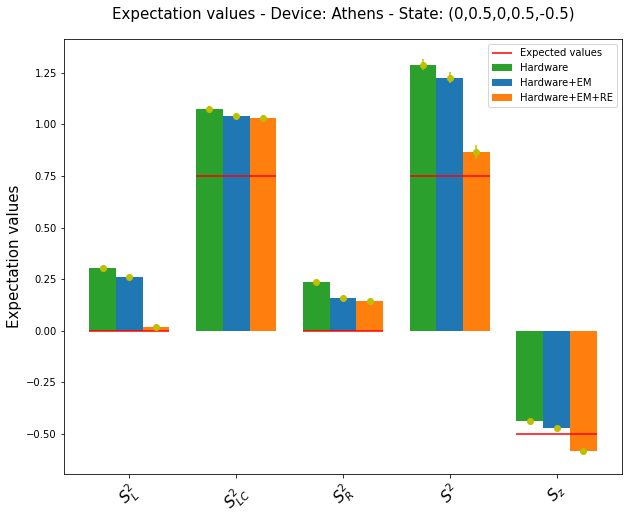

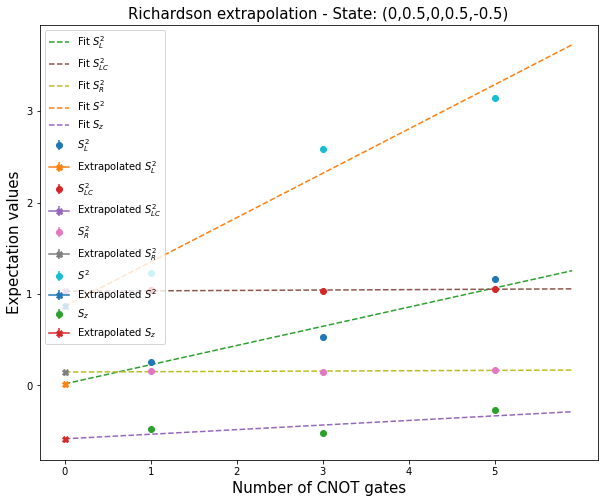

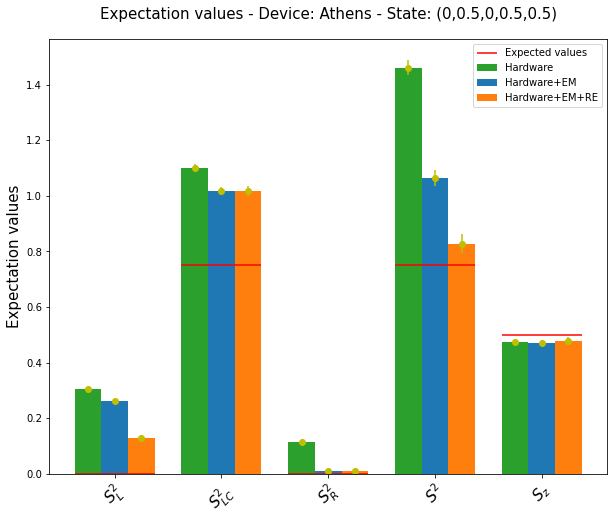

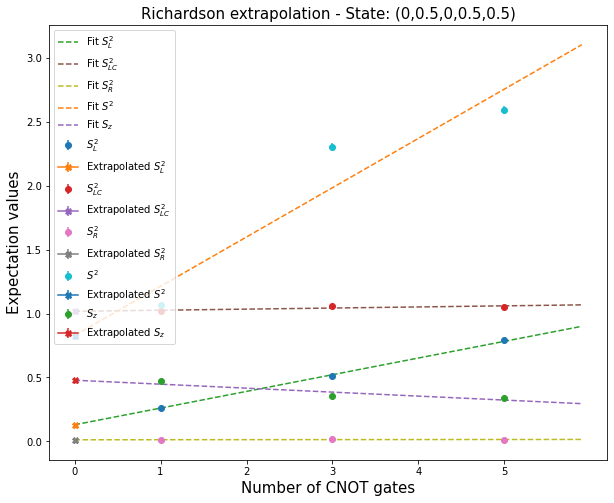

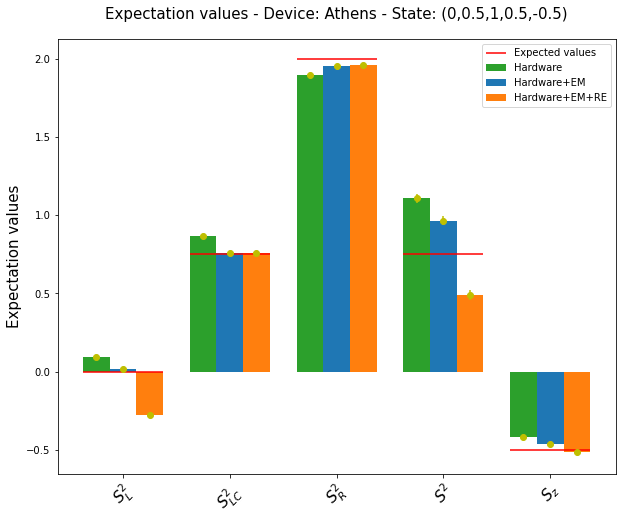

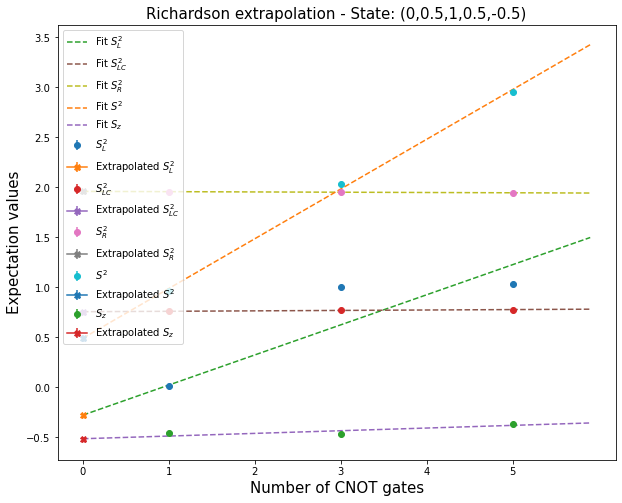

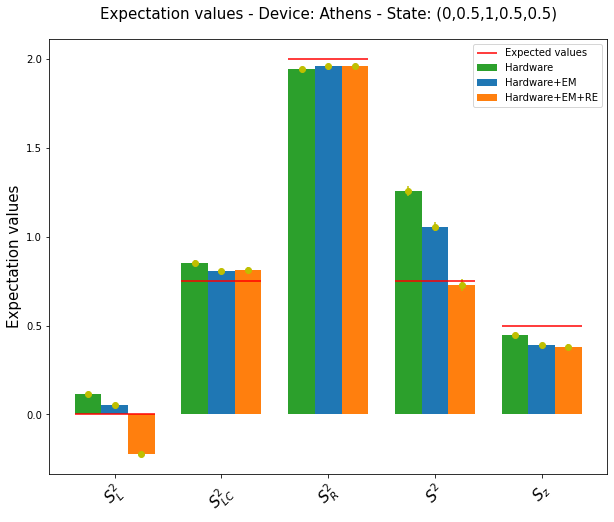

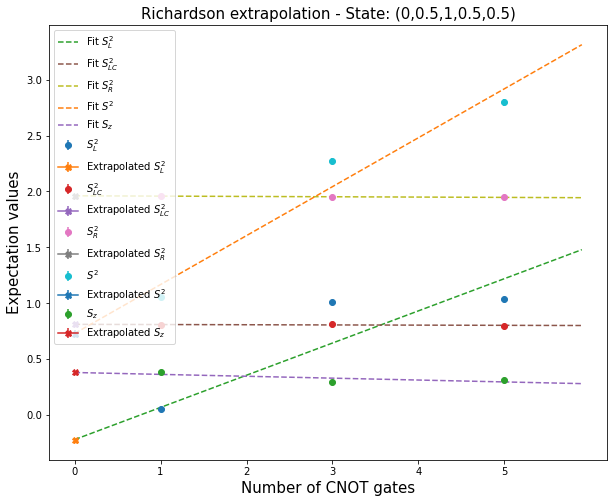

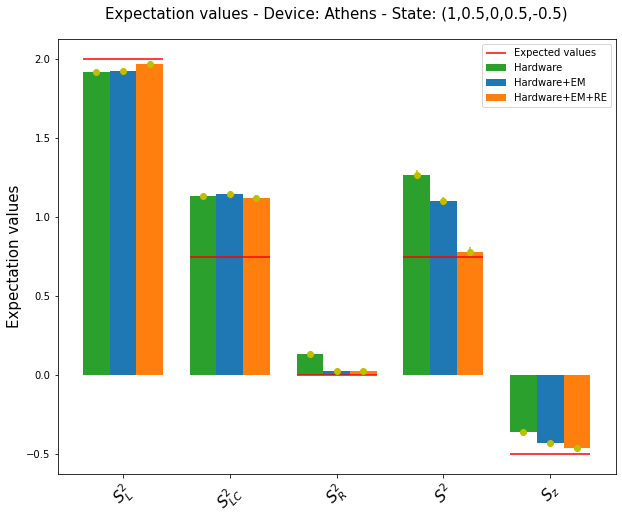

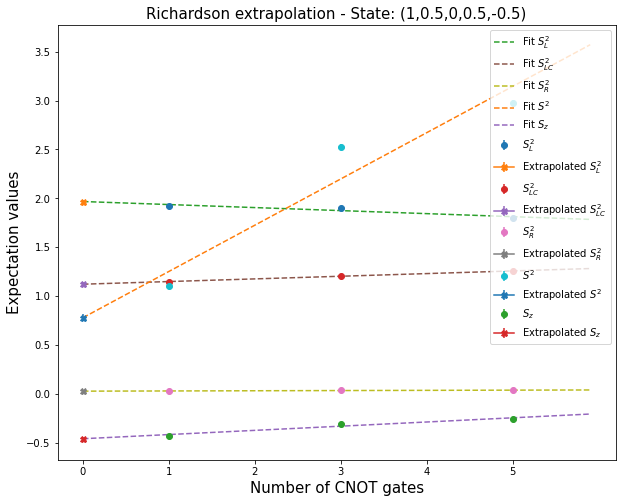

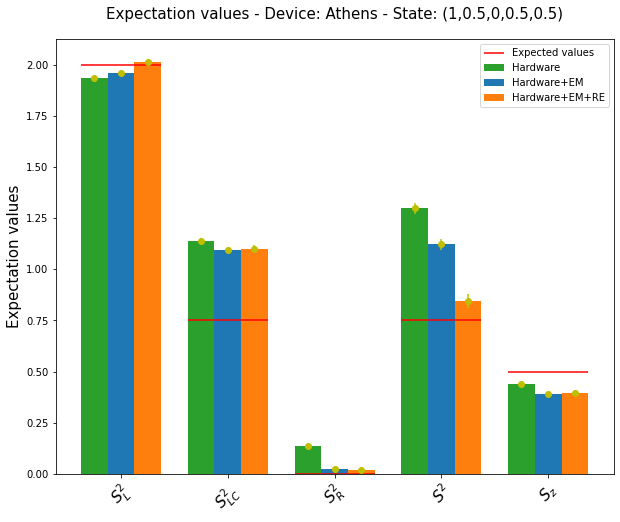

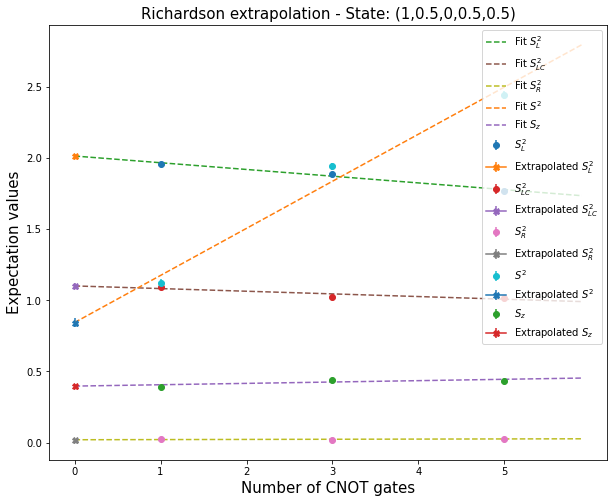

In [22]:
file = open("Results/CG_hardware_5_gs.out")      
line = file.readlines()
line_val = []
for el in line:
    el2 = el.split()
    if el2[0]!="Job":
        line_val.append(el2)

display(Markdown(r"State label: $(s_L,s_{LC},s_R,s,s_z)$"))
        
s= 8192     # Number of shots
cl=0        # Count lines
for i in range(len(lab_list_gs)):
    data_raw,err_raw=[],[]
    data_1,err_1=[],[]
    data_3,err_3=[],[]
    data_5,err_5=[],[]
    data_re,err_re=[],[]
    
    for j in range(20):
        val = line_val[cl]
        if j<5:
            data_raw.append(float(val[0]))
            err_raw.append(float(val[1]))    # Standard deviation!
        elif j>=5 and j<10:
            data_1.append(float(val[0]))
            err_1.append(float(val[1]))      # Standard deviation!
        elif j>=10 and j<15:
            data_3.append(float(val[0]))
            err_3.append(float(val[1]))      # Standard deviation!
        elif j>=15 and j<20:
            data_5.append(float(val[0]))
            err_5.append(float(val[1]))      # Standard deviation!
        cl+=1
    
    for k in range(len(data_1)):
        #print([data_1[k],data_3[k],data_5[k]])
        p_ave, p_cov = curve_fit(straight_line,[1,3,5],[data_1[k],data_3[k],data_5[k]],sigma=[err_1[k],err_3[k],err_5[k]],absolute_sigma=True)
        data_re.append(p_ave[1])
        err_re.append(np.sqrt(p_cov[1,1]))
                                                                                            
                                                                                             
    # The histograms - Plot of expectation values
    l = lab_list_gs[i]
    op_labels=[r"$S_L^2$",r"$S_{LC}^2$",r"$S_R^2$",r"$S^2$",r"$S_z$"]
    
    fig, ax = plt.subplots(figsize=(10,8))
    x_lab = np.arange(5)
    width=0.25

    rects1 = ax.bar(x_lab - width, data_raw, width, label='Hardware',color='tab:green')
    ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color='y')
    
    rects2 = ax.bar(x_lab, data_1, width, label='Hardware+EM',color='tab:blue')
    ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color='y')
    
    rects3 = ax.bar(x_lab + width, data_re, width, label='Hardware+EM+RE',color='tab:orange')
    ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color='y')
    
    ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
    ax.hlines(y=0.5*(0.5+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
    ax.hlines(y=l[1]*(l[1]+1), xmin=2-3*width/2, xmax=2+3*width/2,colors="r")
    ax.hlines(y=0.5*(0.5+1), xmin=3-3*width/2, xmax=3+3*width/2,colors="r")
    ax.hlines(y=l[2], xmin=4-3*width/2, xmax=4+3*width/2,colors="r",label="Expected values")
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Expectation values',fontsize=15)
    ax.set_title(r'Expectation values - Device: Athens - State: ({},0.5,{},0.5,{})'.format(l[0],l[1],l[2]),fontsize=15,pad=20)
    ax.set_xticks(x_lab)
    ax.set_xticklabels(op_labels,rotation=45,size=15)
    ax.legend()
    plt.show()
    
    
    # Richardson extrapolation analysis
    plt.figure(figsize=(10,8))
    for j in range(5):
        # Data
        plt.errorbar([1,3,5],[data_1[j],data_3[j],data_5[j]],yerr=[err_1[j],err_3[j],err_5[j]],marker='o',ls="none",label=op_labels[j])
        # Extrapolated data
        p_ave,p_cov = curve_fit(straight_line,[1,3,5],[data_1[j],data_3[j],data_5[j]],sigma=[err_1[j],err_3[j],err_5[j]],absolute_sigma=True)                                                                                    
        plt.errorbar([0],[p_ave[1]],yerr=[np.sqrt(p_cov[1,1])],marker='X',label='Extrapolated '+op_labels[j])
        # Fit
        u = list(np.arange(0,6,0.1))
        v = [straight_line(ui,p_ave[0],p_ave[1]) for ui in u]
        plt.plot(u,v,'--',label='Fit '+op_labels[j])                                                                                    
    
    plt.title("Richardson extrapolation - State: ({},0.5,{},0.5,{})".format(l[0],l[1],l[2]),size=15)
    plt.xlabel("Number of CNOT gates",size=15)
    plt.xticks(np.arange(6))
    plt.ylabel("Expectation values",size=15)
    plt.legend()
    

### State tomography on CG circuits

It's not possible because of the limited number of tomography circuits needed for external users.

In [21]:
display(Markdown(r"State label: $(s_L,s_{LC},s_R,s,s_z)$"))
for il,l in enumerate(lab_list_gs):
    print("Circuit associated with ( {}, 0.5, {}, 0.5, {} )".format(l[0],l[1],l[2]))
    
    circ = QuantumCircuit(nqubit)
    if l[1]==0:
        ################
        # First 3 qubits
        ################
        l1 = (l[0],0.5,l[2])

        # theta gives the angle to use in the Ry Gate
        theta=np.arccos(get_clebsch(l1[0],l1[2]-0.5,0.5,0.5,l1[1],l1[2]))

        circ.ry(2*theta,2)                                            # Remember that we need to insert 2*theta

        if l1[0]==0:
            circ.cx(2,0)
            circ.ch(2,0)
            circ.cx(2,1)

        elif l1[0]==1:
            if l1[2]+0.5==0:
                circ.ch(2,0)
                circ.cx(2,1)
            elif l1[2]+0.5==-1:
                circ.cx(2,0)

        circ.x(2)

        if l1[0]==0:
            circ.cx(2,0)
            circ.ch(2,0)
            circ.cx(2,1)

        elif l1[0]==1:
            if l1[2]-0.5==0:
                circ.ch(2,0)
                circ.cx(2,1)
            elif l1[2]-0.5==-1:
                circ.cx(2,0)

        circ.x(2)
        circ.cx(0,1)
        
        ################
        # Last 2 qubits
        ################
        l2 = (l[1],l[1])
        if l2[0]==0:
            circ.x(3)
            circ.h(3)
            circ.x(4)
        else:
            if l2[1]==0:
                circ.h(3)
                circ.x(4)
            elif l2[1]==-1:
                circ.x(3)
        circ.cx(3,4)
    
    elif l[1]==1:
        ################
        # Last 3 qubits
        ################
        l1 = (l[1],0.5,l[2])
        
        # theta gives the angle to use in the Ry Gate
        theta=np.arccos(get_clebsch(l1[0],l1[2]-0.5,0.5,0.5,l1[1],l1[2]))

        circ.ry(2*theta,2)                                            # Remember that we need to insert 2*theta

        if l1[0]==0:
            circ.cx(2,3)
            circ.ch(2,3)
            circ.cx(2,4)

        elif l1[0]==1:
            if l1[2]+0.5==0:
                circ.ch(2,3)
                circ.cx(2,4)
            elif l1[2]+0.5==-1:
                circ.cx(2,3)

        circ.x(2)

        if l1[0]==0:
            circ.cx(2,3)
            circ.ch(2,3)
            circ.cx(2,4)

        elif l1[0]==1:
            if l1[2]-0.5==0:
                circ.ch(2,3)
                circ.cx(2,4)
            elif l1[2]-0.5==-1:
                circ.cx(2,3)

        circ.x(2)
        circ.cx(3,4)
        
        ################
        # First 2 qubits
        ################
        l2 = (l[0],l[0])
        if l2[0]==0:
            circ.x(0)
            circ.h(0)
            circ.x(1)
        elif l2[0]==1:
            if l2[1]==0:
                circ.h(0)
                circ.x(1)
            elif l2[1]==-1:
                circ.x(0)
        circ.cx(0,1)
        
    print(circ.draw())
    
    # Target state associated to the circuit on th first three qubits
    target_state = qiskit.quantum_info.Statevector.from_instruction(circ)

    # Generate circuits and run on simulator
    t = time.time()

    # Generate the state tomography circuit
    tomo_circ = state_tomography_circuits(circ,[0,1,2,3,4])

    #############
    # ibmq_athens
    #############

    # Execute
    job = qiskit.execute(tomo_circ, device, shots=8192)
    #print('Time taken:', time.time() - t)

    # Fit result
    tomo_fitter = StateTomographyFitter(job.result(), tomo_circ)

    # NO CORRECTION
    # Perform the tomography fit which outputs a density matrix
    rho_fit = tomo_fitter.fit(method='lstsq')
    #print(rho_fit)
    fid  = qiskit.quantum_info.state_fidelity(rho_fit, target_state)
    print('State Fidelity (no correction): F = {:.5f}'.format(fid))

    # Generate the calibration circuits (Readout Error Mitigation)
    meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1,2,3,4])

    job_cal = qiskit.execute(meas_calibs, backend=device, shots=8192)
    meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

    # WITH CORRECTION
    correct_tomo_results = meas_fitter.filter.apply(job.result(), method='least_squares')
    tomo_mit = StateTomographyFitter(correct_tomo_results, tomo_circ)
    rho_fit_mit = tomo_mit.fit(method='lstsq')
    fid_mit = qiskit.quantum_info.state_fidelity(rho_fit_mit, target_state)
    print('State fidelity (w/ correction): F = {:.5f}'.format(fid_mit))

State label: $(s_L,s_{LC},s_R,s,s_z)$

Circuit associated with ( 0, 0.5, 0, 0.5, -0.5 )
              ┌───┐┌───┐          ┌───┐┌───┐          
q_0: ─────────┤ X ├┤ H ├──────────┤ X ├┤ H ├───────■──
              └─┬─┘└─┬─┘┌───┐     └─┬─┘└─┬─┘┌───┐┌─┴─┐
q_1: ───────────┼────┼──┤ X ├───────┼────┼──┤ X ├┤ X ├
     ┌───────┐  │    │  └─┬─┘┌───┐  │    │  └─┬─┘├───┤
q_2: ┤ RY(π) ├──■────■────■──┤ X ├──■────■────■──┤ X ├
     └─┬───┬─┘┌───┐          └───┘               └───┘
q_3: ──┤ X ├──┤ H ├──■────────────────────────────────
       ├───┤  └───┘┌─┴─┐                              
q_4: ──┤ X ├───────┤ X ├──────────────────────────────
       └───┘       └───┘                              


IBMQJobFailureError: 'Unable to retrieve result for job 60c1d19ce5bd48a52ca9543a. Job has failed: The number of experiments in the Qobj (243) is higher than the number of experiments supported by the device (75). Error code: 1102.'